# Recurrent neural network for time series prediction

This project involves a recurrent neural network (RNN) regressor to forecast the price of Apple stock 7 days in advance. The network will employ [Long Term Short Memory (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) architecture in Keras.

# Initial steps
First we load data of around 140 days of Apple's stock price and perform several pre-processing steps to prepare it for use with an RNN model. We normalize the series to lie in the range of [0,1] to avoid numerical issues associated with how common activation functions (such as tanh) transform large (positive or negative) numbers. Normalization also helps avoid related issues when computing derivatives.

In [1]:
### Load in necessary libraries for data input and normalization
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### load in and normalize the dataset
dataset = np.loadtxt('datasets/normalized_apple_prices.csv')

Lets take a quick look at the (normalized) time series we'll be performing predictions on.

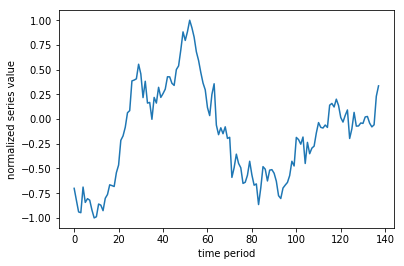

In [2]:
# lets take a look at our time series
plt.plot(dataset)
plt.xlabel('time period')
plt.ylabel('normalized series value')

## Splitting the time series into sequences
The time series is a sequence of numbers that we can generally represent as

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series. To use a regressive RNN with the data, we need to use a sliding window to construct a set of associated input/ouptut pairs on which we can perform regression.

<img src="images/timeseries_windowing_training.gif" width=600 height=600/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Each input is a vector of length 4 and each corresponding output is a scalar. Given a time series of length P and window size T = 5, we created P - 5 input/output pairs. Generally, for window size T, we create P - T pairs.

In [3]:
### TODO: fill out the function below that transforms the input series 
### and window-size into a set of input/output pairs for use with our RNN model
def window_transform_series(series,window_size):
    # containers for input/output pairs
    X = [[series[i+j] for j in range(0, window_size)] for i in range(len(series)-window_size)]
    y = [[series[i]] for i in range(window_size, len(series))]
    
        
    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)
    
    return X,y

Let's test the function on the list of odd numbers given below

In [4]:
odd_nums = np.array([1,3,5,7,9,11,13])

To window this sequence with a window_size = 2 using the **window_transform_series** we should get the following input/output pairs:

In [5]:
# run a window of size 2 over the odd number sequence and display the results
window_size = 2
X,y = window_transform_series(odd_nums,window_size)

# print out input/output pairs --> here input = X, corresponding output = y
print ('--- the input X will look like ----')
print (X)

print ('--- the associated output y will look like ----')
print (y)

print ('the shape of X is ' + str(np.shape(X)))
print ('the shape of y is ' + str(np.shape(y)))
print('the type of X is ' + str(type(X)))
print('the type of y is ' + str(type(y)))

--- the input X will look like ----
[[ 1  3]
 [ 3  5]
 [ 5  7]
 [ 7  9]
 [ 9 11]]
--- the associated output y will look like ----
[[ 5]
 [ 7]
 [ 9]
 [11]
 [13]]
the shape of X is (5, 2)
the shape of y is (5, 1)
the type of X is <class 'numpy.ndarray'>
the type of y is <class 'numpy.ndarray'>


We can check that your completed **window_transform_series** function works correctly by trying it on the odd_nums sequence - you should get the above output.  

Now we can apply the function to the series in the Python cell below.  We use a window_size = 7 for these experiments.

In [6]:
# window the data using your windowing function
window_size = 7
X,y = window_transform_series(series = dataset,window_size = window_size)

## Training and testing sets


We are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [7]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

## The RNN regression model

The RNN in Keras is a two hidden layer RNN with following specifications:

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

In [8]:
# import keras network libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

# given - fix random seed - so we can all reproduce the same results on our default time series
np.random.seed(0)

# TODO: build an RNN to perform regression on our time series input/output data
model = Sequential()
model.add(LSTM(32, input_shape=(window_size, 1)))
model.add(Dense(1))

# build model using keras documentation recommended optimizer initialization
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)

Using TensorFlow backend.


With your model built you can now fit the model by activating the cell below!  Note: the number of epochs (np_epochs) and batch_size are preset (so we can all produce the same results).  You can choose to toggle the verbose parameter - which gives you regular updates on the progress of the algorithm - on and off by setting it to 1 or 0 respectively.

In [9]:
model.fit(X_train, y_train, epochs=1000, batch_size=90, verbose=2)

Epoch 1/1000
1s - loss: 0.2338
Epoch 2/1000
0s - loss: 0.1955
Epoch 3/1000
0s - loss: 0.1724
Epoch 4/1000
0s - loss: 0.1554
Epoch 5/1000
0s - loss: 0.1417
Epoch 6/1000
0s - loss: 0.1302
Epoch 7/1000
0s - loss: 0.1202
Epoch 8/1000
0s - loss: 0.1115
Epoch 9/1000
0s - loss: 0.1037
Epoch 10/1000
0s - loss: 0.0967
Epoch 11/1000
0s - loss: 0.0904
Epoch 12/1000
0s - loss: 0.0847
Epoch 13/1000
0s - loss: 0.0796
Epoch 14/1000
0s - loss: 0.0750
Epoch 15/1000
0s - loss: 0.0710
Epoch 16/1000
0s - loss: 0.0673
Epoch 17/1000
0s - loss: 0.0641
Epoch 18/1000
0s - loss: 0.0613
Epoch 19/1000
0s - loss: 0.0589
Epoch 20/1000
0s - loss: 0.0568
Epoch 21/1000
0s - loss: 0.0550
Epoch 22/1000
0s - loss: 0.0536
Epoch 23/1000
0s - loss: 0.0523
Epoch 24/1000
0s - loss: 0.0513
Epoch 25/1000
0s - loss: 0.0505
Epoch 26/1000
0s - loss: 0.0498
Epoch 27/1000
0s - loss: 0.0492
Epoch 28/1000
0s - loss: 0.0488
Epoch 29/1000
0s - loss: 0.0484
Epoch 30/1000
0s - loss: 0.0481
Epoch 31/1000
0s - loss: 0.0479
Epoch 32/1000
0s 

## Checking model performance

We can now make predictions on both our training and testing sets.

In [10]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [11]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 0.013473066586
testing error = 0.0175030095459


Activating the next cell plots the original data, as well as both predictions on the training and testing sets. 

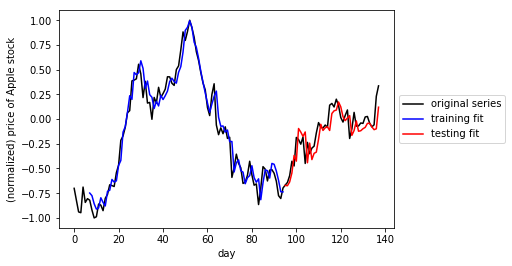

In [12]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of Apple stock')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**Note:** We could use a similar process and model for other adventures in deep learning. If you would like to try another see e.g., [this site containing thousands of time series](https://datamarket.com/data/list/?q=provider%3Atsdl) and pick another one!

With great thanks to Alexis Cook and the AI team at [Udacity](https://www.udacity.com).